In [1]:
import os
import sys

spark_home=os.environ.get('SPARK_HOME',None)

# 使用try ...except来捕捉并提醒没有设置SPARK环境变量，但是程序继续执行，并使用程序内设置的PATH
try:
    if not spark_home:
        raise ValueError('SPARK环境没有配置好')
except Exception as e:
    print('没有配置SPARK的环境变量:',e)
    
spark_home='D:\\green\\spark-2.2.1-bin-2.6.0-cdh5.14.2\\'

sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python\lib\py4j-0.10.4-src.zip'))

exec(open(os.path.join(spark_home,'python\pyspark\shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.2.1
      /_/

Using Python version 3.7.3 (default, Apr 24 2019 15:29:51)
SparkSession available as 'spark'.


In [2]:
import os
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("python_spark_sql_basic_example")  \
    .config("","") \
    .getOrCreate()

# 读取数据
user_data = spark.sparkContext.textFile("hdfs://cdh03:8020/input/u.user")

# 可以加载的数据信息的第一条
user_data.first()

'1|24|M|technician|85711'

In [3]:
# 使用"|"来分割每一行的数据，形成列表
user_fields = user_data.map(lambda line:line.split('|'))

# 统计总的用户数
num_users = user_fields.map(lambda fields:fields[0]).count()

# 统计性别的种类
num_genders = user_fields.map(lambda fields:fields[2]).distinct().count()

# 统计职位的种类数
num_occupations = user_fields.map(lambda fields:fields[3]).distinct().count()

# 统计邮编的种类数
num_zips = user_fields.map(lambda fields:fields[4]).distinct().count()

# 打印统计的这些信息
print("users:%d,genders:%d,occupations:%d,ZIP codes:%d" % (num_users,num_genders,num_occupations,num_zips)) 

users:943,genders:2,occupations:21,ZIP codes:795


Text(0, 0.5, 'Counts')

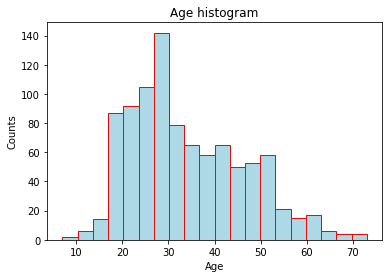

In [18]:
# 可视化展示数据
import matplotlib.pyplot as plt

# 获取用户年龄这一列
ages = user_fields.map(lambda fields:int(fields[1])).collect()

# 创建一个图形实例
fig1 = plt.figure()

plt.hist(ages,bins = 20,color='lightblue',edgecolor='red')

# 用户年龄直方图
plt.title("Age histogram")


# 设置x轴的名称
plt.xlabel("Age")

# 设置y轴的名称
plt.ylabel("Counts")


Text(0.5, 1.0, 'Job distribution')

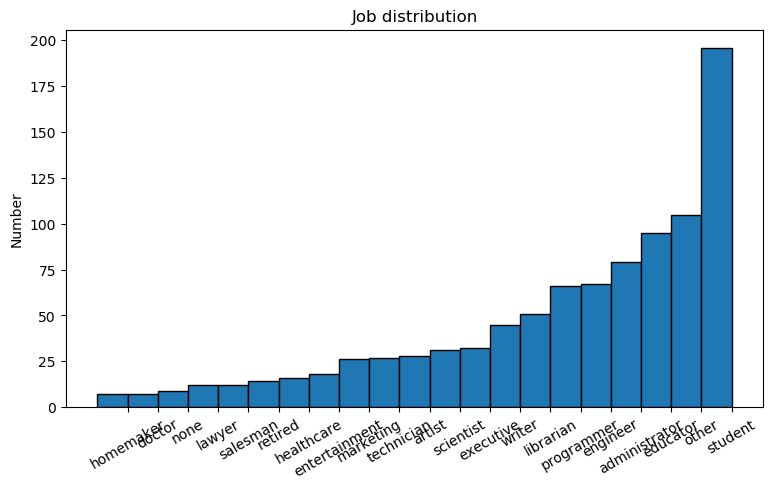

In [9]:
# 职业分布统计
#导入numpy模块
import numpy as np

# 计算各个职业的人数，并且进行升序排序
occupations = user_fields.map(lambda fields: (fields[3], 1)) \
    .reduceByKey(lambda x, y: x + y) \
    .sortBy(lambda x: x[1]) \
    .collect()

fig2 = plt.figure(figsize=(9, 5), dpi=100)

# 提取(职位，人数)中的职位作为x轴
x_axis = [occu[0] for occu in occupations]
# 提取(职位，人数)中的人数作为y轴
y_axis = [occu[1] for occu in occupations]

# 设置柱状图中x轴的范围及width
pos = np.arange(len(x_axis))
width = 1.0
ax = plt.axes()
ax.set_xticks(pos + 0.5)
ax.set_xticklabels(x_axis)
plt.bar(pos, y_axis, width, edgecolor='black')
plt.xticks(rotation=30)
plt.ylabel("Number")
plt.title("Job distribution")

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
总共有1682部电影


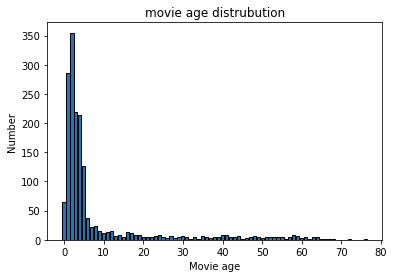

In [16]:
# 电影发布信息统计分析
# 从HDFS中加载u.item
movie_data = spark.sparkContext.textFile("hdfs://cdh03:8020/input/u.item")

# 打印第一条数据
print(movie_data.first())

# 统计电影总数
num_movies = movie_data.count()
print("总共有%d部电影" % num_movies)

# 定义函数，用于对电影数据的预处理，对于错误的年限，使用1900年填补
def convert_year(x):
    try:
        return int(x[-4:])
    except:
        return 1900 #如果有不合格的年份，就直接将其重置为1900 

# 切分数据
movies_column = movie_data.map(lambda line:line.split("|"))

# 日期年份数据，并做脏数据处理
years = movies_column.map(lambda cols:cols[2]).map(lambda x:convert_year(x))

# 过滤掉非1900年的正常数据
years_filtered= years.filter(lambda x:x != 1900)

# 计算出电影发布时间与1998年的差值
movies_ages = years_filtered.map(lambda y:1998-y).countByValue()

# 绘图
y_ais = movies_ages.values()
x_ais = movies_ages.keys()

fig3 = plt.figure()
plt.bar(x_ais,y_ais,edgecolor='black')
plt.title("movie age distrubution")
plt.xlabel("Movie age")
plt.ylabel("Number")
plt.show()



In [21]:
# 用户评分统计
rating_data = spark.sparkContext.textFile("hdfs://cdh03:8020/input/u.data")

print(rating_data.first())

# 统计评分记录总数
num_ratings = rating_data.count()
print("一共有 %d 条评分" % num_ratings)

# 切分字段
rating_data = rating_data.map(lambda line:line.split("\t"))

# 提取对应的用户评分字段
ratings = rating_data.map(lambda cols:int(cols[2]))

# 获取最大评分数
max_rating = ratings.reduce(lambda x,y:max(x,y))

# 获取最小评分数
min_rating = ratings.reduce(lambda x,y:min(x,y))

# 计算电影平均分
avg_rating = ratings.reduce(lambda x,y:x+y) / float(num_ratings)

# 计算每个用户给的平均分
rating_per_user = num_ratings / float(num_users)

# 计算每部电影的平均分
rating_per_movie = num_ratings / float(num_movies)

print("最低分:%d, 最高分:%d, 平均分: %.2f" % (max_rating,min_rating,avg_rating))

print("用户评分的平均分是: %.1f" % (rating_per_user))

print("每部电影的平均得分: %.1f" % (rating_per_movie))



196	242	3	881250949
一共有 100000 条评分
最低分:5, 最高分:1, 平均分: 3.53
用户评分的平均分是: 106.0
每部电影的平均得分: 59.5


Text(0, 0.5, 'Number')

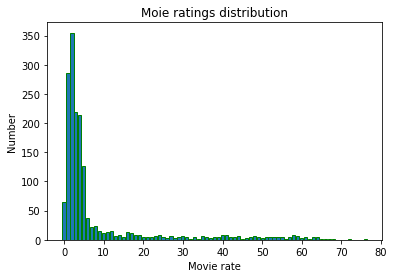

In [23]:
# 绘制分布图
ratings_count = ratings.countByValue()

x_aixs = ratings_count.keys()

y_aixs = ratings_count.values()

fig4 = plt.figure()

plt.bar(x_ais,y_ais,edgecolor='green')
plt.title("Moie ratings distribution")

plt.xlabel("Movie rate")

plt.ylabel("Number")

In [ ]:
# 